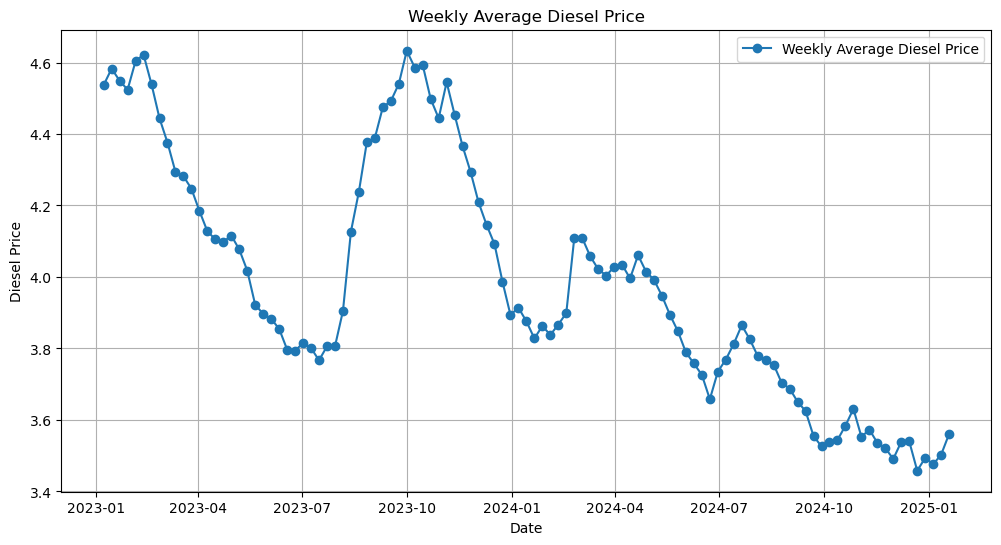

(-1.9729636524061736,
 0.29855193705469696,
 2,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 -267.8116416426643)

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# load data
file_path = 'C:/Users/rongc/Desktop/6980/all_df.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# change date formate
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# pv_week_avg-deisel_price
weekly_diesel_df = df.resample('W', on='Ship Date').agg({
    'pv_week_avg_deisel_price': 'mean'
})

# ADF CHECK
adf_weekly_diesel = sm.tsa.adfuller(weekly_diesel_df['pv_week_avg_deisel_price'].dropna())

# Plot weekly diesel price series
plt.figure(figsize=(12, 6))
plt.plot(weekly_diesel_df['pv_week_avg_deisel_price'], marker='o', linestyle='-', label='Weekly Average Diesel Price')
plt.title('Weekly Average Diesel Price')
plt.xlabel('Date')
plt.ylabel('Diesel Price')
plt.grid(True)
plt.legend()
plt.show()

# Output ADF test results
adf_weekly_diesel


In [ ]:
# ADF: -1.97
# p: 0.299

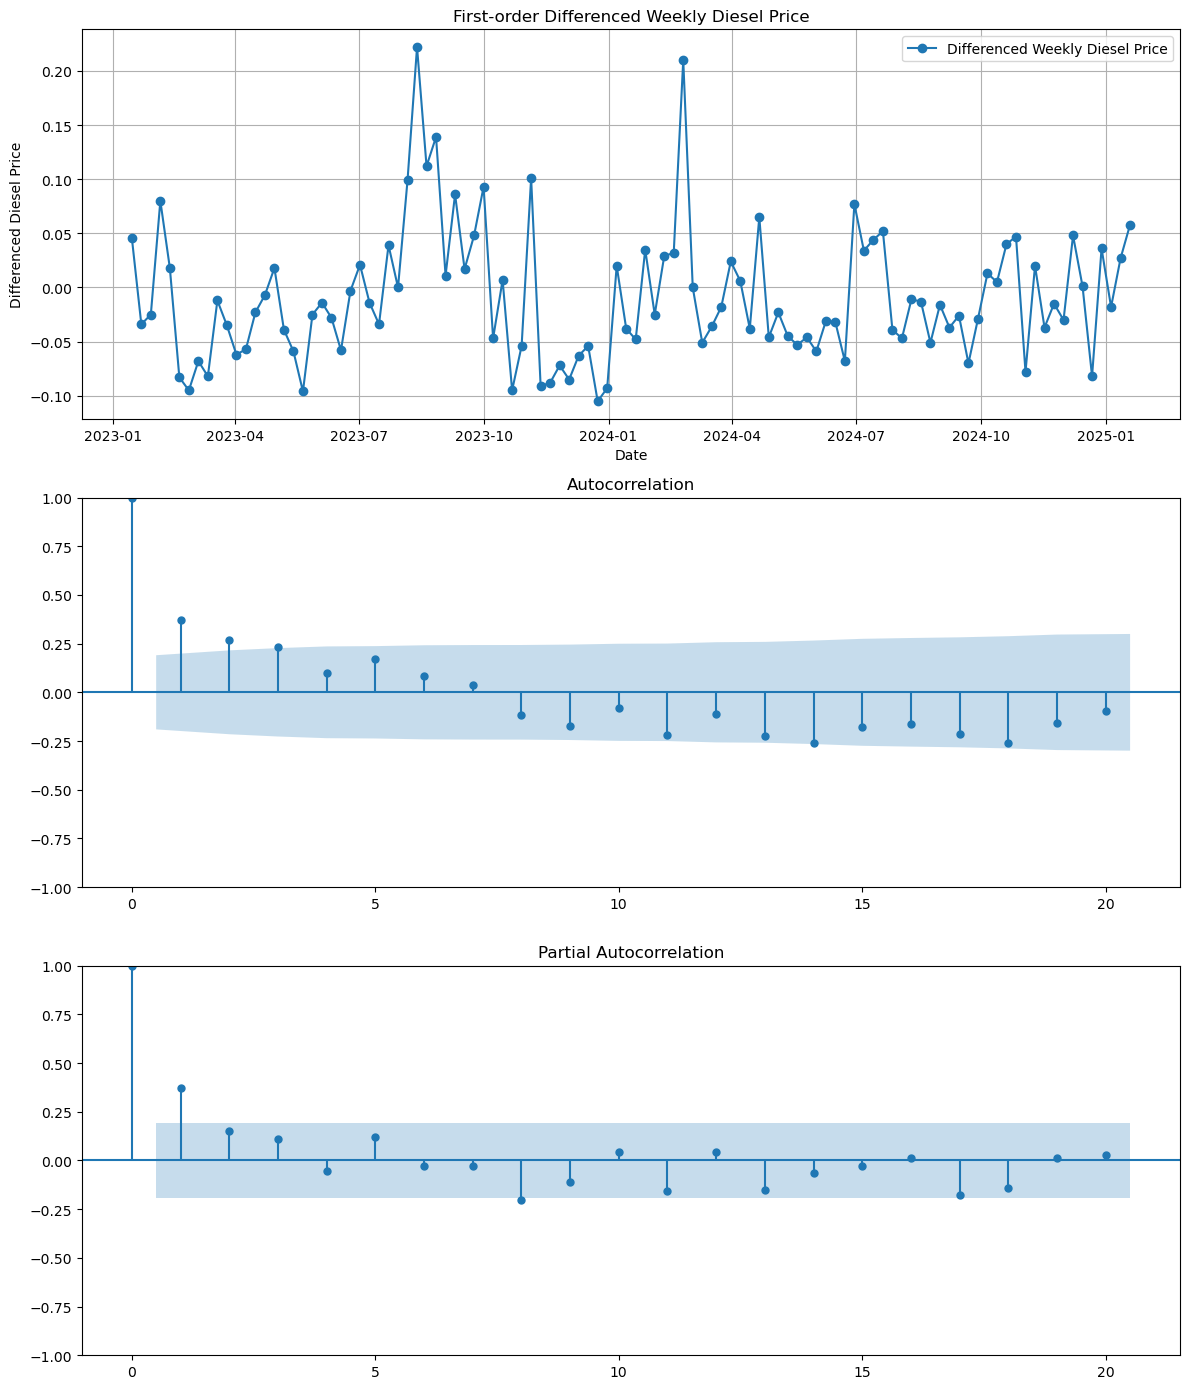

(-4.740655621695278,
 7.053564039649695e-05,
 1,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 -263.0885672820366)

In [27]:
# First-order differential processing makes the data smooth
weekly_diesel_diff = weekly_diesel_df['pv_week_avg_deisel_price'].diff().dropna()

# Re-run the ADF test
adf_test_diff_weekly = sm.tsa.adfuller(weekly_diesel_diff)

# The sequence after the difference and the ACF and PACF plots are drawn
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

axes[0].plot(weekly_diesel_diff, marker='o', linestyle='-', label='Differenced Weekly Diesel Price')
axes[0].set_title('First-order Differenced Weekly Diesel Price')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Differenced Diesel Price')
axes[0].grid(True)
axes[0].legend()

# Plot ACF and PACF maps (lags adjusted as appropriate)
sm.graphics.tsa.plot_acf(weekly_diesel_diff, lags=20, ax=axes[1])
sm.graphics.tsa.plot_pacf(weekly_diesel_diff, lags=20, ax=axes[2], method='ywm')

plt.tight_layout()
plt.show()

# Output ADF test results after difference
adf_test_diff_weekly


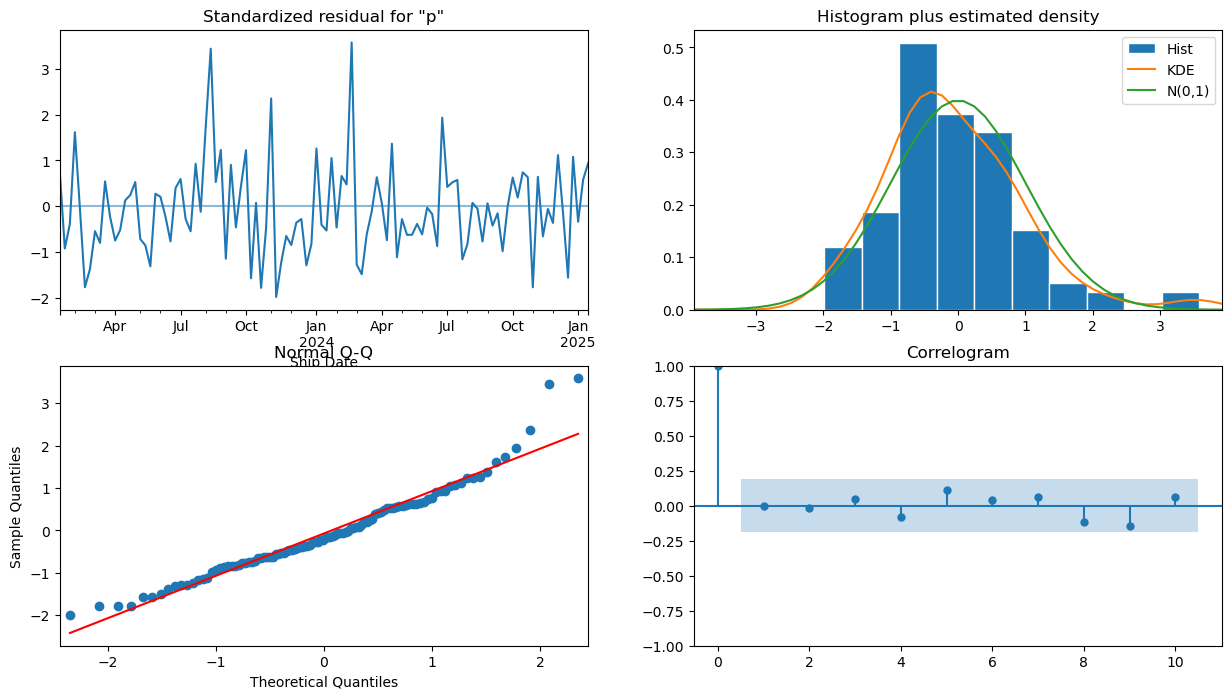

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     pv_week_avg_deisel_price   No. Observations:                  107
Model:                     SARIMAX(1, 1, 1)   Log Likelihood                 156.604
Date:                      Mon, 24 Mar 2025   AIC                           -307.208
Time:                              16:07:52   BIC                           -299.217
Sample:                          01-08-2023   HQIC                          -303.969
                               - 01-19-2025                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7497      0.163      4.588      0.000       0.429       1.070
ma.L1         -0.4398      0.212     -2.073      0.038      -0.856      -0.024
sigma2         0.0030      0.000      9.224      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.10
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.91
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Fit the SARIMA(1,1,1)(0,0,0) model
sarima_weekly_diesel = sm.tsa.statespace.SARIMAX(
    weekly_diesel_df['pv_week_avg_deisel_price'],
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0)
)
results_weekly_diesel = sarima_weekly_diesel.fit()

# Output model summary
model_summary_weekly_diesel = results_weekly_diesel.summary()

# Residual diagnostic diagram
results_weekly_diesel.plot_diagnostics(figsize=(15, 8))
plt.show()

model_summary_weekly_diesel


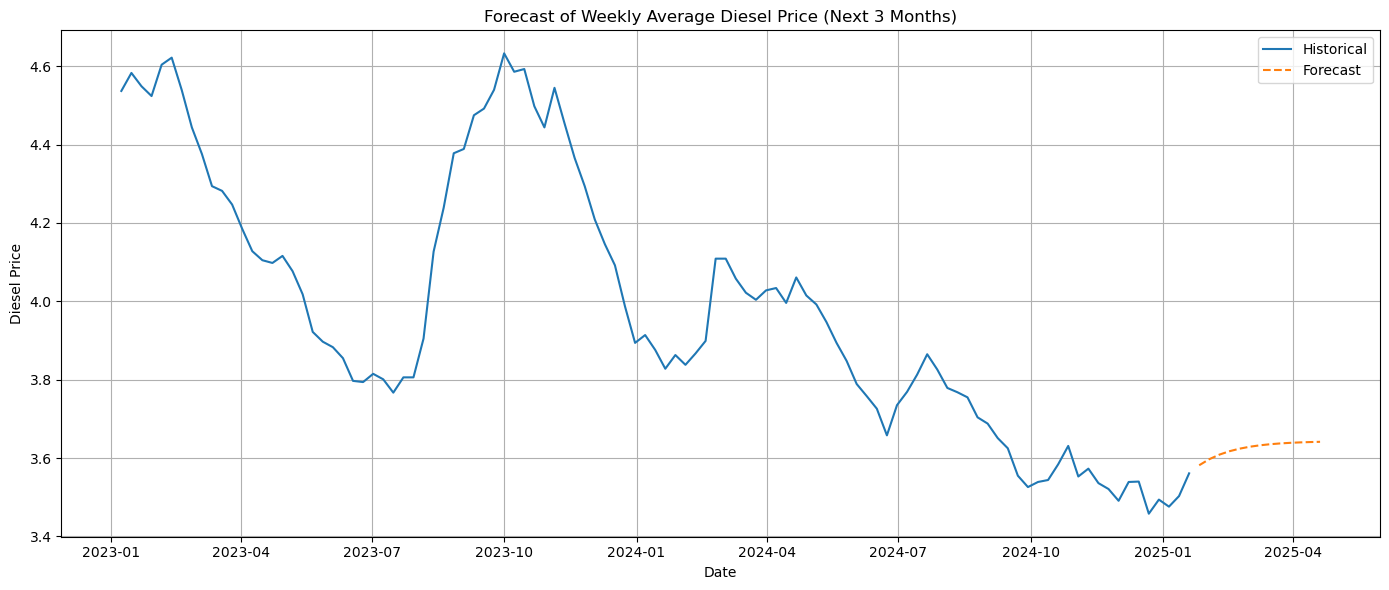

 Diesel Price Forecast (Next 3 months - Weekly):
            Predicted Diesel Price  Lower CI  Upper CI
2025-01-26                3.581643  3.473529  3.689756
2025-02-02                3.597118  3.418949  3.775287
2025-02-09                3.608719  3.364701  3.852736
2025-02-16                3.617415  3.310856  3.923974
2025-02-23                3.623935  3.258080  3.989790
2025-03-02                3.628822  3.206852  4.050793
2025-03-09                3.632486  3.157442  4.107531
2025-03-16                3.635233  3.109965  4.160500
2025-03-23                3.637292  3.064437  4.210147
2025-03-30                3.638835  3.020808  4.256863


In [23]:
# Forecast diesel prices for the next 3 months (about 13 weeks)
forecast_steps = 13  # about 3 months
forecast_result = results_weekly_diesel.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int()

# Build a forecast time index
last_date = weekly_diesel_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

# Combine the forecast results with the time index
forecast_df = pd.DataFrame({
    'Predicted Diesel Price': forecast_mean.values,
    'Lower CI': forecast_conf_int.iloc[:, 0].values,
    'Upper CI': forecast_conf_int.iloc[:, 1].values
}, index=future_dates)
# Drawing section
plt.figure(figsize=(14, 6))
plt.plot(weekly_diesel_df['pv_week_avg_deisel_price'], label='Historical')
plt.plot(forecast_df['Predicted Diesel Price'], label='Forecast', linestyle='--')
plt.title('Forecast of Weekly Average Diesel Price (Next 3 Months)')
plt.xlabel('Date')
plt.ylabel('Diesel Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Show forecast diesel prices for the next 3 months (weekly)
print(" Diesel Price Forecast (Next 3 months - Weekly):")
print(forecast_df.head(10))  



In [21]:

columns_needed = ['Primary Load Number', 'Fuel_per_mile', 'pv_week_avg_deisel_price']
df_filtered = df[columns_needed].dropna()

# Estimate the cost of fuel per shipment (in the field, Fuel_per_mile is the cost per mile and pv_week_avg_deisel_price is the price per gallon)
# Estimated_Gallons = Fuel_Cost / Diesel_Price = Fuel_per_mile / Diesel_Price (unit: per mile)
df_filtered['Estimated_Gallons_per_mile'] = df_filtered['Fuel_per_mile'] / df_filtered['pv_week_avg_deisel_price']

# Assume savings per $0.01/gallon saved
saving_per_gallon = 0.1
df_filtered['Cost_Saving_per_mile'] = df_filtered['Estimated_Gallons_per_mile'] * saving_per_gallon

# Summary statistics
average_saving_per_mile = df_filtered['Cost_Saving_per_mile'].mean()
total_saving_estimate = df_filtered['Cost_Saving_per_mile'].sum()

# Output the first few lines of sample
print("Partial transportation savings simulation (per $0.01 diesel savings):")
print(df_filtered[['Primary Load Number', 'Fuel_per_mile', 'pv_week_avg_deisel_price', 'Estimated_Gallons_per_mile', 'Cost_Saving_per_mile']].head())

# Summary statistics result
print(" Simulation summary：")
print(f"Total number of shipments: {len(df_filtered)}")
print(f"Average savings per transportation mile (USD) : ${round(average_saving_per_mile, 4)}")
print(f"Total savings per transportation mile (US $): ${round(total_saving_estimate, 2)}")




Partial transportation savings simulation (per $0.01 diesel savings):
   Primary Load Number  Fuel_per_mile  pv_week_avg_deisel_price  \
0            421429203       0.703093                     4.537   
1            422081427       0.688833                     4.537   
2            422082170       0.674265                     4.537   
3            422091472       0.688833                     4.537   
4            422094222       0.728678                     4.537   

   Estimated_Gallons_per_mile  Cost_Saving_per_mile  
0                    0.154969              0.015497  
1                    0.151826              0.015183  
2                    0.148615              0.014861  
3                    0.151826              0.015183  
4                    0.160608              0.016061  
 Simulation summary：
Total number of shipments: 1331
Average savings per transportation mile (USD) : $0.0149
Total savings per transportation mile (US $): $19.79
